## Onshore Wind in the UK

In this project I want to create an interactive dashboard using a data on onshore wind projects in the UK. The datasource is: https://www.gov.uk/government/publications/renewable-energy-planning-database-monthly-extract (BEIS).

I want to be able to display the following:
- Current output of wind turbines in MW
- Historical output
- Development over time (applications submitted, successful applications, rejected, decomissioned)
- Forecast energy losses from wind turbines reaching EOL (25 years)
- Whether the current onshore wind turbine pipeline will meet targets. (one such target: Renewable UK suggests 30GW of onshore wind by 2030 https://www.renewableuk.com/news/583055/Industry-urges-Government-to-set-new-target-to-double-UK-onshore-wind-capacity-by-2030.htm)



In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import numpy as np

In [3]:
csv = 'onshore_wind_2.csv'
data = pd.read_csv(csv, low_memory=False)

In [4]:
df = pd.DataFrame(data)
df.head(3)

,Old Ref ID,Ref ID,Record Last Updated (dd/mm/yyyy),Operator (or Applicant),Site Name,Technology Type,Storage Type,Storage Co-location REPD Ref ID,Installed Capacity (MWelec),CHP Enabled,...,Appeal Refused,Appeal Granted,Planning Permission Granted,Secretary of State - Intervened,Secretary of State - Refusal,Secretary of State - Granted,Planning Permission Expired,Under Construction,Operational,Heat Network Ref
0,01015W4,2549,03/08/2005,Ecotricity,Stockton Wind Turbine,Wind Onshore,NaN,NaN,1.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01016W4,2550,02/05/2006,Western Windpower / Ecotricity,Brundish Wind Turbine,Wind Onshore,NaN,NaN,1.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01022W5,2554,27/10/2009,ECONET LTD,Yare Estuary Wind Turbine,Wind Onshore,NaN,NaN,1.5,NaN,...,NaN,NaN,28/04/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2333 entries, 0 to 2332
Data columns (total 51 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Old Ref ID                               1794 non-null   object 
 1   Ref ID                                   2333 non-null   int64  
 2   Record Last Updated (dd/mm/yyyy)         2314 non-null   object 
 3   Operator (or Applicant)                  2284 non-null   object 
 4   Site Name                                2332 non-null   object 
 5   Technology Type                          2333 non-null   object 
 6   Storage Type                             2 non-null      object 
 7   Storage Co-location REPD Ref ID          59 non-null     object 
 8   Installed Capacity (MWelec)              2308 non-null   float64
 9   CHP Enabled                              256 non-null    object 
 10  RO Banding (ROC/MWh)                     59 non-

This dataset contains 50 columns in total. Not all of them are needed for our research. Let's have a look a them in detail below. The screenshot is from the original database Definition Sheet.

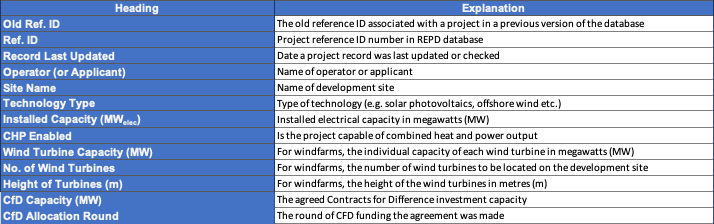
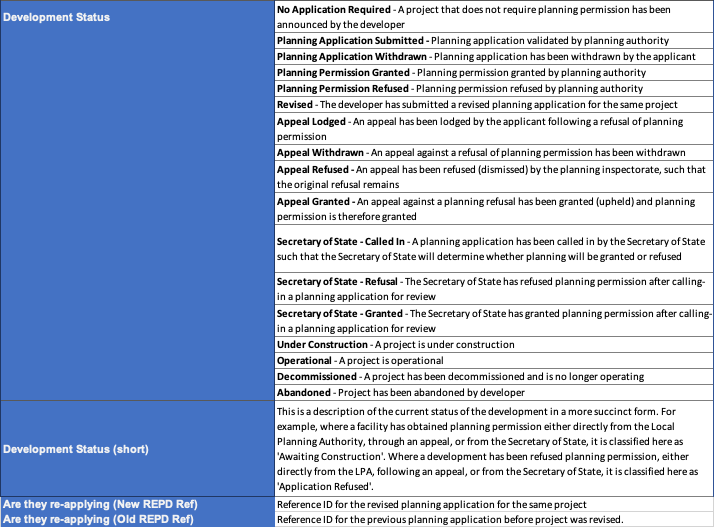
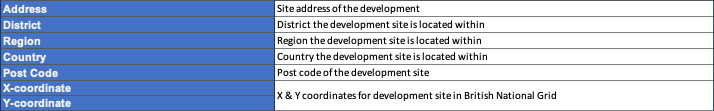
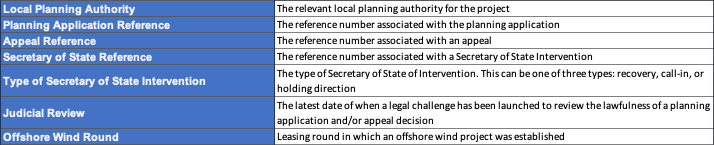
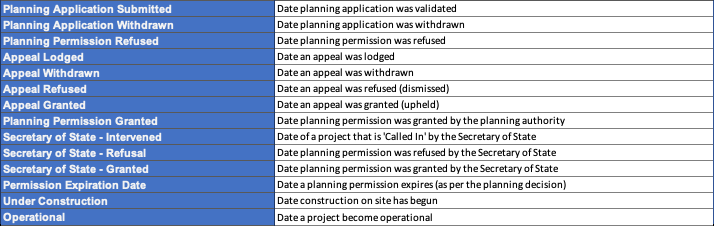

In this study we'll be looking at onshore wind capacity, development over time, geographic distribution and forecasting. So quite a lot of these columns are unnecessary and to simplify our work, we'll drop a few of them now.

The dataset also originally contained other renewable energy sources, so some of the columns are not relevant to us e.g. storage type and CHP enabled. Furthermore, a number of columns have very small amounts of non-null rows, so we won't be able to do much with that data anyway.

In [6]:
not_needed = ['Old Ref ID', 'Storage Type','Storage Co-location REPD Ref ID', 'CHP Enabled',
             'Mounting Type for Solar','Offshore Wind Round','Heat Network Ref', 'Technology Type',
             'RO Banding (ROC/MWh)', 'FiT Tariff (p/kWh)', 'CfD Capacity (MW)', 'CfD Allocation Round',
             'Secretary of State Reference', 'Type of Secretary of State Intervention', 'Judicial Review',
             'Secretary of State - Intervened', 'Secretary of State - Refusal', 'Secretary of State - Granted',
             'Are they re-applying (New REPD Ref)', 'Are they re-applying (Old REPD Ref) ']

In [7]:
df = df.drop(columns=not_needed)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2333 entries, 0 to 2332
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Ref ID                            2333 non-null   int64  
 1   Record Last Updated (dd/mm/yyyy)  2314 non-null   object 
 2   Operator (or Applicant)           2284 non-null   object 
 3   Site Name                         2332 non-null   object 
 4   Installed Capacity (MWelec)       2308 non-null   float64
 5   Turbine Capacity (MW)             2147 non-null   float64
 6   No. of Turbines                   2232 non-null   float64
 7   Height of Turbines (m)            673 non-null    float64
 8   Development Status                2333 non-null   object 
 9   Development Status (short)        2333 non-null   object 
 10  Address                           2320 non-null   object 
 11  County                            2333 non-null   object 
 12  Region

### Data cleaning
First thing, we need to tidy up the data to work with and take a look at its structure.

Tasks:
 - tidy up the column names
 - convert date columns to datetime

In [9]:
# Tidy up column names

new_cols = []

for item in df.columns:
    item = item.lower()
    item = item.replace(' ', '_')
    item = item.replace('(', '')
    item = item.replace(')', '')
    item = item.replace('/', '')
    item = item.replace('.', '')
    item = item.replace('-', '')
    new_cols.append(item)
    
df.columns = new_cols
df.columns

Index(['ref_id', 'record_last_updated_ddmmyyyy', 'operator_or_applicant',
       'site_name', 'installed_capacity_mwelec', 'turbine_capacity_mw',
       'no_of_turbines', 'height_of_turbines_m', 'development_status',
       'development_status_short', 'address', 'county', 'region', 'country',
       'post_code', 'xcoordinate', 'ycoordinate', 'planning_authority',
       'planning_application_reference', 'appeal_reference',
       'planning_application_submitted', 'planning_application_withdrawn',
       'planning_permission_refused', 'appeal_lodged', 'appeal_withdrawn',
       'appeal_refused', 'appeal_granted', 'planning_permission_granted',
       'planning_permission_expired', 'under_construction', 'operational'],
      dtype='object')

In [10]:
#Rename some of the more annoying column titles
df.rename(columns={'record_last_updated_ddmmyyyy':'last_updated',
                   'installed_capacity_mwelec':'capacity_mw',
                   'xcoordinate':'xcoord', 'ycoordinate':'ycoord'}, inplace=True)

In [11]:
df.columns

Index(['ref_id', 'last_updated', 'operator_or_applicant', 'site_name',
       'capacity_mw', 'turbine_capacity_mw', 'no_of_turbines',
       'height_of_turbines_m', 'development_status',
       'development_status_short', 'address', 'county', 'region', 'country',
       'post_code', 'xcoord', 'ycoord', 'planning_authority',
       'planning_application_reference', 'appeal_reference',
       'planning_application_submitted', 'planning_application_withdrawn',
       'planning_permission_refused', 'appeal_lodged', 'appeal_withdrawn',
       'appeal_refused', 'appeal_granted', 'planning_permission_granted',
       'planning_permission_expired', 'under_construction', 'operational'],
      dtype='object')

In [12]:
import datetime
#Date columns to datetime

date_cols = ['last_updated', 'planning_application_submitted', 'planning_application_withdrawn',
            'planning_permission_refused', 'appeal_lodged', 'appeal_withdrawn', 
            'appeal_refused', 'appeal_granted', 'planning_permission_granted',
            'planning_permission_expired', 'under_construction', 'operational']

df[date_cols] = df[date_cols].apply(pd.to_datetime, format='%d/%m/%Y')

### Analysis: Energy output in MW, current and historical

We're going to take a look at how the onshore wind turbine industry has developed in terms of its energy output to the UK grid.

We can see that some of the columns relate to planning permission. There are a number of entries in the dataset for failed projects and such. These may be of interest to us at some point, but for now they are not -- we're only interested in projects that actually got up and running, producing energy. So firstly, we need to filter our datset for those.

In [13]:
#Checking the available statuses of projects to see which is/are most relevant
df['development_status'].unique()

array(['Planning Permission Refused', 'Abandoned', 'Operational',
       'Planning Application Withdrawn', 'Appeal Refused', 'Revised',
       'Planning Permission Expired', 'Planning Permission Granted',
       'Under Construction', 'Planning Application Submitted',
       'Decommissioned', 'Appeal Withdrawn', 'Appeal Granted',
       'Secretary of State - Refusal', 'Secretary of State - Granted',
       'Appeal Lodged', ' Appeal Granted', 'No Application Required'],
      dtype=object)

In [14]:
#Quick check if this column will be of use

df['operational'].unique()[0:5]

array([                          'NaT', '2000-07-22T00:00:00.000000000',
       '1999-08-16T00:00:00.000000000', '1998-04-18T00:00:00.000000000',
       '2005-01-25T00:00:00.000000000'], dtype='datetime64[ns]')

Both the above columns will be helpful for us with our question. We'll filter our dataset for just the 'operational' and 'decommissioned' projects in the Development Status column. We'll leave out the 'under construction' projects for now, but will look at them again later when projecting forward. We'll use the Operational column to then sort our onshore wind projects by time.

In [15]:
energy_producers = df[(df['development_status'] == 'Operational') | (df['development_status'] == 'Decommissioned')]

In [16]:
energy_producers = energy_producers.sort_values(by='operational', ascending=True)

In [17]:
energy_producers

,ref_id,last_updated,operator_or_applicant,site_name,capacity_mw,turbine_capacity_mw,no_of_turbines,height_of_turbines_m,development_status,development_status_short,...,planning_application_withdrawn,planning_permission_refused,appeal_lodged,appeal_withdrawn,appeal_refused,appeal_granted,planning_permission_granted,planning_permission_expired,under_construction,operational
240,2948,2015-01-09,Wind Electric,Delabole Wind Farm,4.0,0.40,10.0,NaN,Decommissioned,Decommissioned,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1991-11-01
216,2921,2009-07-06,Yorkshire Water,Chelker Reservoir,1.3,0.30,4.0,NaN,Operational,Operational,...,NaT,NaT,NaT,NaT,NaT,NaT,1991-07-12,NaT,NaT,1992-06-01
284,3005,2015-01-09,Scottish Power Renewables,Carland Cross,6.0,0.40,15.0,NaN,Decommissioned,Decommissioned,...,NaT,NaT,NaT,NaT,NaT,NaT,1992-04-29,NaT,NaT,1992-08-27
823,3659,2013-10-08,Border Wind Farms Ltd,Blyth Harbour Wind Farm,2.7,0.30,9.0,NaN,Operational,Operational,...,NaT,NaT,NaT,NaT,NaT,NaT,1992-03-06,NaT,NaT,1992-12-01
107,2713,2019-08-05,Npower Renewables,Kirkby Moor,4.8,0.40,12.0,NaN,Operational,Operational,...,NaT,2017-06-13,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1993-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2105,7562,2020-09-23,Statkraft UK,Windy Rig Wind Farm,43.0,3.00,12.0,125.0,Operational,Operational,...,NaT,NaT,NaT,NaT,NaT,NaT,2019-11-08,2022-11-07,2020-03-01,2022-01-10
1981,6422,2023-03-16,Cleanearth,Graig Fatha Farm,2.5,2.50,1.0,126.0,Operational,Operational,...,NaT,NaT,NaT,NaT,NaT,NaT,2018-03-14,2023-03-14,2021-10-01,2022-02-01
2054,7304,NaT,Green Cat Renewables,Deuchries Windfarm (extension),2.0,1.00,2.0,119.0,Operational,Operational,...,NaT,NaT,NaT,NaT,NaT,NaT,2019-10-08,2022-10-08,NaT,2022-04-01
1424,4300,2023-01-16,ERG,Creag Riabhach Wind Farm,90.0,4.20,22.0,125.0,Operational,Operational,...,NaT,NaT,NaT,NaT,NaT,NaT,2016-10-17,NaT,2021-05-24,2023-01-12


I want to make sure we're not double-counting some of the projects. For example, the Carland Cross site run by Socttish Power Renewables was decommissioned, but it's not clear when exactly. We know it began operations in 1992 by the Operational column. If there is more than one entry of this site then we might need to be more careful not to double-count the energy output later.

In [18]:
energy_producers[energy_producers['site_name'] == 'Carland Cross']

,ref_id,last_updated,operator_or_applicant,site_name,capacity_mw,turbine_capacity_mw,no_of_turbines,height_of_turbines_m,development_status,development_status_short,...,planning_application_withdrawn,planning_permission_refused,appeal_lodged,appeal_withdrawn,appeal_refused,appeal_granted,planning_permission_granted,planning_permission_expired,under_construction,operational
284,3005,2015-01-09,Scottish Power Renewables,Carland Cross,6.0,0.4,15.0,NaN,Decommissioned,Decommissioned,...,NaT,NaT,NaT,NaT,NaT,NaT,1992-04-29,NaT,NaT,1992-08-27


Just the one entry. It seems entries are updated when a project is decommissioned, rather than a new entry being added. That's helpful for us. Given the last update for this site was in 2015, we'll take this as the decommissioning date.

### Calculating output over time

Wind turbines are manufactured with a maximum energy output capacity in megawatts (MW). However, they typically do not output maximum capacity most of their life. This is largely due to how well the wind blows, but other factors can be involved too (maintenance downtime, etc). This is known as the load factor.

The BEIS releases load factor data annually, and can be found in Table 6.3 from the government website (https://www.gov.uk/government/statistics/renewable-sources-of-energy-chapter-6-digest-of-united-kingdom-energy-statistics-dukes). Onshore wind factors go back to 1997. For years prior, we'll use the 1997 figure. We'll also use the 2021 figure for years 2022 and 2023.

I want to create a chart that shows us the capacity of each project in megawatts (MW) over time. From our column summary at the top, we can see that the turbine_capacity_mw column relates to the capacity of each turbine on the site, while the capacity_mw column (originally 'installed_capacity_mw_elec') is the total capacity of the site. We'll use the latter column for our work.

We'll be looking at the data annually for now -- so let's group the data by year to make this simpler.

We'll calculate the cumulative capacity of the all the projects as time progresses. We want to make sure to remove the capacity of decommissioned projects as they are removed from the energy supply chain, so we'll need to check for the decommissioned date.

In [19]:
#Create filter to find decommissioned projects
decom_filter = energy_producers['development_status'] == 'Decommissioned'

#Add a new column with decommission year (inferred from last_updated) for above projects,
energy_producers['decom_year'] = energy_producers['last_updated']
energy_producers['decom_year'].loc[~decom_filter] = np.NaN
energy_producers['decom_year'] = energy_producers['decom_year'].dt.year.astype('Int64').fillna(np.NaN)

/var/folders/jb/5csh6qnx4y7brg28_7d39qyw0000gq/T/ipykernel_79945/418851329.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_producers['decom_year'].loc[~decom_filter] = np.NaN


In [20]:
energy_producers

,ref_id,last_updated,operator_or_applicant,site_name,capacity_mw,turbine_capacity_mw,no_of_turbines,height_of_turbines_m,development_status,development_status_short,...,planning_permission_refused,appeal_lodged,appeal_withdrawn,appeal_refused,appeal_granted,planning_permission_granted,planning_permission_expired,under_construction,operational,decom_year
240,2948,2015-01-09,Wind Electric,Delabole Wind Farm,4.0,0.40,10.0,NaN,Decommissioned,Decommissioned,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1991-11-01,2015
216,2921,2009-07-06,Yorkshire Water,Chelker Reservoir,1.3,0.30,4.0,NaN,Operational,Operational,...,NaT,NaT,NaT,NaT,NaT,1991-07-12,NaT,NaT,1992-06-01,<NA>
284,3005,2015-01-09,Scottish Power Renewables,Carland Cross,6.0,0.40,15.0,NaN,Decommissioned,Decommissioned,...,NaT,NaT,NaT,NaT,NaT,1992-04-29,NaT,NaT,1992-08-27,2015
823,3659,2013-10-08,Border Wind Farms Ltd,Blyth Harbour Wind Farm,2.7,0.30,9.0,NaN,Operational,Operational,...,NaT,NaT,NaT,NaT,NaT,1992-03-06,NaT,NaT,1992-12-01,<NA>
107,2713,2019-08-05,Npower Renewables,Kirkby Moor,4.8,0.40,12.0,NaN,Operational,Operational,...,2017-06-13,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1993-01-01,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2105,7562,2020-09-23,Statkraft UK,Windy Rig Wind Farm,43.0,3.00,12.0,125.0,Operational,Operational,...,NaT,NaT,NaT,NaT,NaT,2019-11-08,2022-11-07,2020-03-01,2022-01-10,<NA>
1981,6422,2023-03-16,Cleanearth,Graig Fatha Farm,2.5,2.50,1.0,126.0,Operational,Operational,...,NaT,NaT,NaT,NaT,NaT,2018-03-14,2023-03-14,2021-10-01,2022-02-01,<NA>
2054,7304,NaT,Green Cat Renewables,Deuchries Windfarm (extension),2.0,1.00,2.0,119.0,Operational,Operational,...,NaT,NaT,NaT,NaT,NaT,2019-10-08,2022-10-08,NaT,2022-04-01,<NA>
1424,4300,2023-01-16,ERG,Creag Riabhach Wind Farm,90.0,4.20,22.0,125.0,Operational,Operational,...,NaT,NaT,NaT,NaT,NaT,2016-10-17,NaT,2021-05-24,2023-01-12,<NA>


In [21]:
decom_projects = energy_producers[energy_producers['decom_year'] > 0]

In [22]:
decom_projects

,ref_id,last_updated,operator_or_applicant,site_name,capacity_mw,turbine_capacity_mw,no_of_turbines,height_of_turbines_m,development_status,development_status_short,...,planning_permission_refused,appeal_lodged,appeal_withdrawn,appeal_refused,appeal_granted,planning_permission_granted,planning_permission_expired,under_construction,operational,decom_year
240,2948,2015-01-09,Wind Electric,Delabole Wind Farm,4.0,0.40,10.0,NaN,Decommissioned,Decommissioned,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1991-11-01,2015
284,3005,2015-01-09,Scottish Power Renewables,Carland Cross,6.0,0.40,15.0,NaN,Decommissioned,Decommissioned,...,NaT,NaT,NaT,NaT,NaT,1992-04-29,NaT,NaT,1992-08-27,2015
283,3004,2015-01-09,REG Windpower (previously Cornwall Light and P...,Goonhilly Downs - Wind,5.6,0.40,14.0,NaN,Decommissioned,Decommissioned,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1993-01-01,2015
219,2925,2015-12-17,NaN,Ovenden Moor,9.2,0.40,23.0,NaN,Decommissioned,Decommissioned,...,NaT,NaT,NaT,NaT,NaT,1992-07-02,NaT,NaT,1993-06-01,2015
580,3358,2015-01-09,ECONET LTD,Blood Hill Wind Farm,2.3,0.15,10.0,NaN,Decommissioned,Decommissioned,...,1999-08-06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2000-07-24,2015
1174,4036,2015-01-09,Scottish and Southern Energy (SSE),Spurness Wind Farm,11.0,2.75,4.0,NaN,Decommissioned,Decommissioned,...,NaT,NaT,NaT,NaT,NaT,2003-01-01,NaT,NaT,2004-12-01,2015
1709,4609,2019-11-05,Scottish Enterprise/SSE,Hunterston Test Centre,13.0,7.00,2.0,NaN,Decommissioned,Decommissioned,...,NaT,NaT,NaT,NaT,NaT,2012-02-14,NaT,2013-03-21,2015-12-15,2019


In [23]:
decom_projects_capacities = decom_projects.groupby('decom_year')['capacity_mw'].sum()

In [24]:
decom_projects_capacities

decom_year
2015    38.1
2019    13.0
Name: capacity_mw, dtype: float64

In [25]:
decom_projects_capacities = pd.DataFrame(decom_projects_capacities).reset_index()

In [26]:
decom_projects_capacities

,decom_year,capacity_mw
0,2015,38.1
1,2019,13.0


In [27]:
#Sum capacity for each year MINUS any projects that have been decommissioned that year
#Cumulatively sum the years afterwards

#Adding a column with just the year of operations beginning
energy_producers['start_year'] = energy_producers['operational'].dt.year.astype('Int64')

#Sum for each year, then subtract the decomissioned 
years_grouped = energy_producers.groupby('start_year')['capacity_mw'].sum()
years_mw = pd.DataFrame(years_grouped).reset_index()
years_mw

,start_year,capacity_mw
0,1991,4.0
1,1992,10.0
2,1993,75.1
3,1994,25.4
4,1995,30.6
5,1996,70.4
6,1997,59.3
7,1998,17.1
8,1999,20.9
9,2000,56.4


In [28]:
years_mw = pd.merge(years_mw, decom_projects_capacities, how='left', left_on='start_year', right_on='decom_year')

In [29]:
years_mw = years_mw.drop(columns='decom_year').rename(columns={'capacity_mw_y':'decom_capacity'
                                                    , 'capacity_mw_x':'ops_capacity'})

In [30]:
years_mw['decom_capacity'] = years_mw['decom_capacity'].fillna(0)

In [31]:
years_mw['total'] = years_mw['ops_capacity'] - years_mw['decom_capacity']

In [32]:
years_mw

,start_year,ops_capacity,decom_capacity,total
0,1991,4.0,0.0,4.0
1,1992,10.0,0.0,10.0
2,1993,75.1,0.0,75.1
3,1994,25.4,0.0,25.4
4,1995,30.6,0.0,30.6
5,1996,70.4,0.0,70.4
6,1997,59.3,0.0,59.3
7,1998,17.1,0.0,17.1
8,1999,20.9,0.0,20.9
9,2000,56.4,0.0,56.4


In [33]:
years_mw['cumulative_capacity'] = years_mw['total'].cumsum()

In [34]:
load_factors = [27.22,27.22,27.22,27.22,27.22,27.22,
                27.22,30.66,28.2,27.37,23.8,28,24.09,26.65,26.43,
                27.18,27.46,26.71,27.21,21.85,27.94,25.83,28.37,
                26.22,29.34,23.57,27.99,26.66,26.52,28.33,23.24,
               23.24,23.24]

In [35]:
#Calculating the likely actual output (in KWh) based on the capacity factors.
#We calculate this by multiplying the capacity by 8760 (hours in a year), by the load factor
#The numbers are quite large to we'll conver to Gigawatt hours (GWh) for ease by dividing by 1,000,000

#Add in the load_factors
years_mw['load_factor'] = load_factors

#Calculation
years_mw['GWh_annual'] = (years_mw['cumulative_capacity'] * 8760 * years_mw['load_factor'])/1_000_000

In [36]:
years_mw

,start_year,ops_capacity,decom_capacity,total,cumulative_capacity,load_factor,GWh_annual
0,1991,4.0,0.0,4.0,4.0,27.22,0.953789
1,1992,10.0,0.0,10.0,14.0,27.22,3.338261
2,1993,75.1,0.0,75.1,89.1,27.22,21.245646
3,1994,25.4,0.0,25.4,114.5,27.22,27.302204
4,1995,30.6,0.0,30.6,145.1,27.22,34.598689
5,1996,70.4,0.0,70.4,215.5,27.22,51.385372
6,1997,59.3,0.0,59.3,274.8,27.22,65.525291
7,1998,17.1,0.0,17.1,291.9,30.66,78.398969
8,1999,20.9,0.0,20.9,312.8,28.20,77.271610
9,2000,56.4,0.0,56.4,369.2,27.37,88.519835


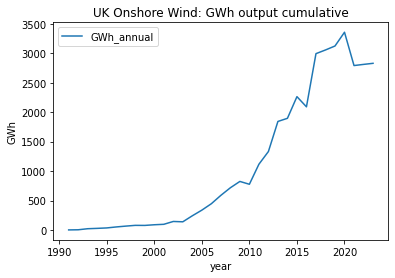

In [37]:
ax1 = years_mw.plot(x='start_year', y='GWh_annual')
plt.title('UK Onshore Wind: GWh output cumulative')
plt.ylabel('GWh')
plt.xlabel('year')
plt.show()